In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import cv2
import numpy as np
from collections import Counter
import matplotlib.image as mpimg
from sklearn.preprocessing import LabelBinarizer

In [2]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def normalize_grayscale(X):
    a,b,xmin,xmax = 0.1,0.9,0,255
    return a+(X-xmin)*(b-a)/(xmax-xmin)

def grayscale_4d(X):
    X_gray = np.empty(X[:,:,:,0].shape)
    for i in range(len(X_gray)):
        X_gray[i] = normalize_grayscale(grayscale(X[i]))
    return(X_gray)

def flat_3d(X):
    n, a,b = X.shape[0],X.shape[1],X.shape[2]
    X_flat = np.empty((n,a*b))
    for i in range(len(X_flat)):
        X_flat[i] = X[i].reshape(a*b)
    return(X_flat)

def shuffle_in_unison(a, b):
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

def flatten_x(x):
    # Get the shape of the input layer.
    x_shape = x.shape

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
#     num_features = x_shape[1:4].num_elements()
    num_features = np.prod(x_shape[1:4])
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    x_flat = np.reshape(x, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return x_flat, num_features

In [3]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = 'lab 2 data/train.p'
testing_file = 'lab 2 data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train_cls = train['features'], train['labels']
X_test, y_test_cls = test['features'], test['labels']

X_train,y_train_cls = shuffle_in_unison(X_train, y_train_cls)

X_train = normalize_grayscale(X_train)

X_train_flat, X_train_flat_features = flatten_x(X_train)

# X_train = grayscale_4d(X_train)
# X_test = grayscale_4d(X_test)

# X_train = flat_3d(X_train)
# X_test = flat_3d(X_test)

In [4]:
num_channels = 3
img_size = 32
img_size_flat = img_size * img_size
img_shape = (img_size, img_size, num_channels)
num_classes = len(Counter(y_train_cls)) #43

In [57]:
encoder = LabelBinarizer()
encoder.fit(y_train_cls)
y_train = encoder.transform(y_train_cls).astype(np.float32)
y_test = encoder.transform(y_test_cls).astype(np.float32)

(39209, 43)

In [6]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

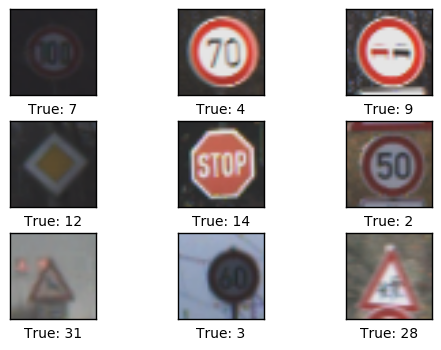

In [44]:
# Get the first images from the test-set.
images = X_train_flat[30:39]

# Get the true classes for those images.
cls_true = y_train_cls[30:39]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

### Helpers

In [8]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [9]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [10]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=False): # Use Rectified Linear Unit (ReLU)?

    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    layer = tf.matmul(input, weights) + biases

    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [11]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

In [12]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

### Placeholders

In [13]:
# x = tf.placeholder(tf.float32, [None, img_shape])
x = tf.placeholder(tf.float32, [None, img_size, img_size, num_channels])

y_true = tf.placeholder(tf.float32, [None, num_classes])
y_true_cls = tf.placeholder(tf.int64, [None]) # is this correct? see tutorial 2

# probability for dropout
keep_prob = tf.placeholder("float")

### Variables to optimize

In [14]:
# OLD
# weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))
# biases = tf.Variable(tf.zeros([num_classes]))

# Uses function but also OLD
# weights = new_weights(shape=[img_size_flat, num_classes])
# biases = new_biases(length=num_classes)

### Model

In [15]:
# logits = tf.matmul(x, weights) + biases
# layer = tf.nn.relu(logits)

# First convolutional layer
conv1_filter_size = 5
conv1_num_filters = 16

layer_conv1, weights_conv1 = new_conv_layer(x,              # The previous layer.
                   num_channels, # Num. channels in prev. layer.
                   conv1_filter_size,        # Width and height of each filter.
                   conv1_num_filters,        # Number of filters.
                   use_pooling=True)  # Use 2x2 max-pooling.

layer_dropout1 = tf.nn.dropout(layer_conv1, keep_prob)

# Second convolutional layer

conv2_filter_size = 5
conv2_num_filters = 24

layer_conv2, weights_conv2 = new_conv_layer(layer_dropout1,              # The previous layer.
                   conv1_num_filters, # Num. channels in prev. layer.
                   conv2_filter_size,        # Width and height of each filter.
                   conv2_num_filters,        # Number of filters.
                   use_pooling=True)  # Use 2x2 max-pooling.

layer_dropout2 = tf.nn.dropout(layer_conv2, keep_prob)

# Third convolutional layer

conv3_filter_size = 5
conv3_num_filters = 32

layer_conv3, weights_conv3 = new_conv_layer(layer_dropout2,              # The previous layer.
                   conv2_num_filters, # Num. channels in prev. layer.
                   conv3_filter_size,        # Width and height of each filter.
                   conv3_num_filters,        # Number of filters.
                   use_pooling=True)  # Use 2x2 max-pooling.

layer_dropout3 = tf.nn.dropout(layer_conv3, keep_prob)

# Flatten second conv layer for FC layer

layer_flat, num_features = flatten_layer(layer_dropout3)

# First FC layer

fc1_out_features = 32

layer_fc1 = new_fc_layer(layer_flat,          # The previous layer.
                 num_features,     # Num. inputs from prev. layer.
                 fc1_out_features,    # Num. outputs.
                 use_relu=True) # Use Rectified Linear Unit (ReLU)?

# Last FC layer

layer_last = new_fc_layer(layer_fc1,          # The previous layer.
                 fc1_out_features,     # Num. inputs from prev. layer.
                 num_classes,    # Num. outputs.
                 use_relu=False) # Use Rectified Linear Unit (ReLU)?

# get predicted class

y_pred = tf.nn.softmax(layer_last)
y_pred_cls = tf.argmax(y_pred, dimension=1)


# cost function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_last, labels=y_true)
# cross_entropy = -tf.reduce_sum(y_true * tf.log(tf.clip_by_value(layer,1e-10,1.0)), reduction_indices=1)
cost = tf.reduce_mean(cross_entropy)

### Optimizer

In [16]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cost)

### Measuring performance

In [17]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Run

In [18]:
session = tf.Session()
session.run(tf.initialize_all_variables())

In [19]:
batch_size = 512

In [20]:
def optimize(num_iterations):
    for i in range(num_iterations):
        
        batch_start = i*batch_size % len(X_train)
        batch_end = min(batch_start+batch_size,len(X_train))
        x_batch = X_train[batch_start:batch_end]
        y_true_batch = y_train[batch_start:batch_end]
        y_true_batch_cls = y_train_cls[batch_start:batch_end]
        
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        # Note that the placeholder for y_true_cls is not set
        # because it is not used during training.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch,
                           keep_prob: 0.5}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        _, batch_cost = session.run([optimizer, cost], feed_dict=feed_dict_train)
        
        # Print status every 100 iterations.
        if i % 20 == 0:
            feed_dict_train_accuracy = {x: x_batch, y_true: y_true_batch, y_true_cls: y_true_batch_cls, keep_prob: 1.0}
            acc = session.run(accuracy, feed_dict=feed_dict_train_accuracy)
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}, Batch Cost: {2}"
            print(msg.format(i + 1, acc, batch_cost))

### Helper-functions to show performance

In [21]:
feed_dict_test = {x: X_test,
                  y_true: y_test,
                  y_true_cls: y_test_cls,
                  keep_prob: 1.0}

In [22]:
def print_accuracy():
    # Use TensorFlow to compute the accuracy.
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))

In [23]:
def print_confusion_matrix():
    # Get the true classifications for the test-set.
    cls_true = y_test_cls
    
    # Get the predicted classifications for the test-set.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

In [24]:
def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = X_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = y_test_cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [25]:
def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(5, 10)
    fig.subplots_adjust(hspace=1, wspace=1)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<num_classes:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("W: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])

## Performance before any optimization 

In [30]:
correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

#     # Negate the boolean array.
#     incorrect = (correct == False)
    
#     # Get the images from the test-set that have been
#     # incorrectly classified.
#     images = X_test[incorrect]
    
#     # Get the predicted classes for those images.
#     cls_pred = cls_pred[incorrect]

#     # Get the true classes for those images.
#     cls_true = y_test_cls[incorrect]
    
#     # Plot the first 9 images.
#     plot_images(images=images[0:9],
#                 cls_true=cls_true[0:9],
#                 cls_pred=cls_pred[0:9])

In [31]:
correct.shape

(12630,)

In [32]:
cls_pred.shape

(12630,)

In [ ]:
# plot_example_errors()

In [ ]:
# plot_weights()

In [ ]:
# print_confusion_matrix()

## Performance after 1 optimization iteration

In [ ]:
optimize(num_iterations=1)
print_accuracy()

In [ ]:
# plot_example_errors()

In [ ]:
# plot_weights()

In [ ]:
# print_confusion_matrix()

## More iterations

In [ ]:
for i in range(10):
    optimize(num_iterations=100)
    print_accuracy()

In [ ]:
# plot_weights()

In [ ]:
# print_confusion_matrix()

In [ ]:
for i in range(10):
    optimize(num_iterations=100)
    print_accuracy()

In [ ]:
for i in range(10):
    optimize(num_iterations=100)
    print_accuracy()

In [ ]:
for i in range(10):
    optimize(num_iterations=100)
    print_accuracy()

In [ ]:
for i in range(10):
    optimize(num_iterations=100)
    print_accuracy()

In [ ]:
for i in range(10):
    optimize(num_iterations=100)
    print_accuracy()

In [ ]:
for i in range(10):
    optimize(num_iterations=100)
    print_accuracy()

In [ ]:
for i in range(10):
    optimize(num_iterations=1000)
    print_accuracy()

In [63]:
# set up data in this shape:
# X_new is (n,32,32,3)
# y_new is (n,43)
# y_new_cls is (n,)

# then get the predicted class for each one


img1 = mpimg.imread('img1.jpg')
img2 = np.copy(img1)
X_new = np.concatenate((img1,img2), axis=0).reshape(-1,32,32,3)
y_new_cls = np.array([14,14])
encoder = LabelBinarizer()
encoder.fit(y_train_cls)
y_new = encoder.transform(y_new_cls).astype(np.float32)

feed_dict_new = {x: X_new,
                  y_true: y_new,
                  y_true_cls: y_new_cls,
                  keep_prob: 1.0}

correct, cls_pred = session.run([correct_prediction, y_pred_cls], feed_dict=feed_dict_new)
print(cls_pred)

[8 8]


In [ ]:
y_test_cls.shape